<a href="https://colab.research.google.com/github/anthony0625/calcium-data/blob/heatmaps/heatmaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydendroheatmap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pydendroheatmap as pdh
import numpy as np
import matplotlib.pyplot as plt
import scipy, csv
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
from scipy.spatial.distance import pdist
from sklearn.cluster import AffinityPropagation, SpectralClustering, KMeans
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from io import StringIO

np.set_printoptions(precision=4, suppress=True)
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

class temp():
    def __init__(self, data, path, k=2, length=20, noise=None, res=None):
        self.results = self.getResults(path, length, res)
        self.frames = self.clean(self.results[:,0:2], length)
        self.length = length
        self.data = data
        self.k = k
        self.path = path
        self.res = res
        #self.primary = np.zeros((np.shape(self.frames)[0], (self.length-self.k) * (np.shape(data)[1])))


        self.primary = np.zeros((np.shape(data)[1], self.length))

        for trial in range(np.shape(self.frames)[0]):
            mat = self.data[self.frames[trial, 0]:self.frames[trial, 1], :]
            mat = np.real(np.fft.fft(np.transpose(mat), axis=1))
            self.primary = self.primary + mat[:,:length]

        '''
        for trial in range(np.shape(self.frames)[0]):
            print(data)
            #mat = self.data[self.frames[trial,0]:self.frames[trial,1], ]
            mat = np.real(np.fft.fft(mat, axis=0))
            self.primary = self.primary + a
        '''
        
        '''
        for trial in range(np.shape(self.frames)[0]):
            vec = self.data[self.frames[trial,0]:self.frames[trial,1], 0:]
            vec = np.real(np.fft.fft(vec, axis=0))
            vec = vec[self.k:self.length]
            self.primary[trial,:] = np.ndarray.flatten(np.transpose(vec))
        '''
        self.primary = self.scale(self.primary)
        
        
        #self.primary = np.transpose(self.primary)
        self.heatMap(self.primary, self.res, self.length)
        #self.dend(self.primary)
        
    def scale(self, data):
        #print(data)
        #scaler = StandardScaler()
        scaler = MinMaxScaler()
        #print(scaler.transform(data))
        return scaler.fit_transform(data)


    def clean(self, frames, length):
        for trial in range(np.shape(frames)[0]):
            if frames[trial,1]-frames[trial,0]<length:
                return self.clean(frames[np.arange(len(frames))!=trial] ,length)
        return frames


    def plot(self, data, length):
        plt.style.use('default')
        title = "Frame " + str(self.frames[0]) + " to " + str(self.frames[1])
        plt.figure(figsize=(4,2), dpi=150)
        plt.title(title)
        for cell in range(np.shape(self.data)[1]):
            plt.plot(np.arange(0,length,1), self.data[:,cell][:])
    
    def getResults(self, path, length, res):
        results_c = []
        #results_i = []
        with open(path) as csvfile:
            reader = csv.reader(csvfile, delimiter = ",")
            for row in reader:
                if res==None:
                    if row[4]=="clean" and row[3]==res and int(row[7])-int(row[5])>length:
                        results_c.append(row)
                elif row[4]=="clean" and row[3]==res and int(row[7])-int(row[5])>length:
                    results_c.append(row)
                #results.append(row)
                #elif row[4]=="clean" and row[3]=="incorrect" and int(row[7])-int(row[5])>length:
                #   results_i.append(row)
        results_c = np.array(results_c, dtype=object)
        #results_i = np.array(results_i, dtype=object)
        turn = results_c[1:,3]#2 for LR 3 for correct/incorrect
        new_turn = np.zeros(np.shape(turn)[0])
        for i in range(np.shape(turn)[0]):
            if turn[i] == "correct":
                new_turn[i] = 1
            else:
                new_turn[i] = 0
        new_turn = new_turn[..., None]
        results_c = np.transpose(np.stack((results_c[1:,5], results_c[1:,7])))#5 for start, 8 for end, 7 for turn
        results_c = np.concatenate((results_c,new_turn),axis=1).astype(int)

        return results_c#, reuslts_i #returns frames + results

    def dend(self, data):
        Z = linkage(data, "ward")
        fig = plt.figure(figsize=(10,20))
        #fig = plt.figure(figsize=(7,5))
        dn = dendrogram(Z, orientation="right")
        plt.show()

    def spec(self, data):
        clustering = SpectralClustering(n_clusters=5, assign_labels="discretize").fit(data)
        print(clustering.labels_)

    '''
    def heatMap(self):
        methods = [None, 'none', 'nearest', 'bilinear', 'bicubic', 'spline16',
           'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
           'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']
        grid = np.random.rand(4, 4)
        fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(9, 6),
                                subplot_kw={'xticks': [], 'yticks': []})
        for ax, interp_method in zip(axs.flat, methods):
            ax.imshow(grid, interpolation=interp_method, cmap='viridis')
            ax.set_title(str(interp_method))
        plt.tight_layout()
        plt.show()
    
    def heatMap(self, data):
        fig = plt.figure(figsize=(20,20))
        plt.imshow(np.transpose(data))
        plt.show()
    '''
    def heatMap(self, data, res, length):
        #heatmap_array = 
        heatmap = pdh.DendroHeatMap(heat_map_data=data)
        heatmap.title = res, length
        #heatmap.row_labels = np.arange(np.shape(data)[0])
        heatmap.colormap = heatmap.yellowBlackBlue
        heatmap.show()

Mounted at /content/drive


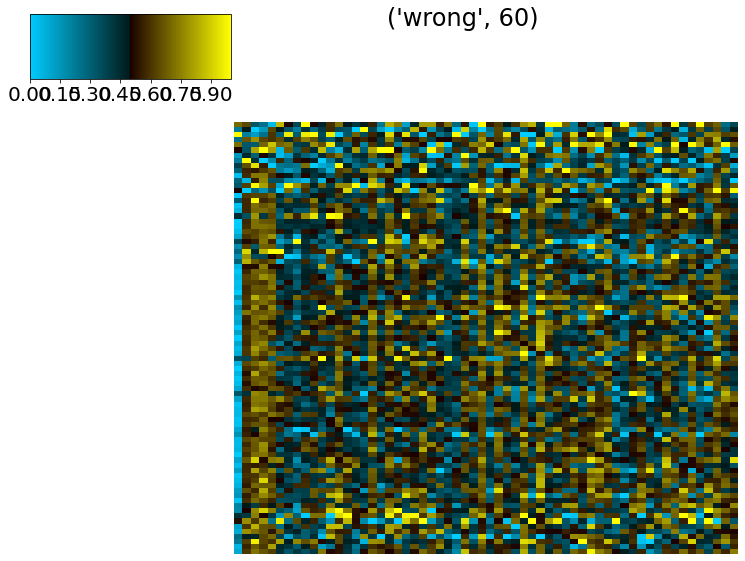

In [ ]:
a = temp(data, params, length=60, res="wrong")

In [ ]:
#path = "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m11n/s1/05_06_2022___15_20_00/calcium_raw_05_06_2022___15_20_00.csv"
path = "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s2/05_17_2022___16_15_20/calcium_raw_05_17_2022___16_15_20.csv"
data = np.genfromtxt(path, delimiter = ",")[1:,1:]

params = "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s2/05_17_2022___16_15_20/trial_parameters_05_17_2022___16_15_20.csv"



In [ ]:
print(np.std(np.array([0,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5])))

2.495670992423109
